In [10]:
!pip install pyspark


In [11]:
import requests
import matplotlib.pyplot as plt
from datetime import datetime
import time
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
import pandas as pd
import requests
import matplotlib.pyplot as plt
from datetime import datetime
import time
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import findspark
import matplotlib.pyplot as plt
import numpy as np
import pyspark
from google.colab import drive
drive.mount('/content/drive')
from datetime import datetime


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Cài đặt Java 11
!apt-get install openjdk-11-jdk -qq

# Tải Spark 3.5.0 kèm Hadoop 3.3
!wget -q https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz

# Giải nén Spark
!tar xf spark-3.5.0-bin-hadoop3.tgz


Selecting previously unselected package fonts-dejavu-core.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../0-fonts-dejavu-core_2.37-2build1_all.deb ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package fonts-dejavu-extra.
Preparing to unpack .../1-fonts-dejavu-extra_2.37-2build1_all.deb ...
Unpacking fonts-dejavu-extra (2.37-2build1) ...
Selecting previously unselected package libxtst6:amd64.
Preparing to unpack .../2-libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package libxxf86dga1:amd64.
Preparing to unpack .../3-libxxf86dga1_2%3a1.1.5-0ubuntu3_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.1.5-0ubuntu3) ...
Selecting previously unselected package x11-utils.
Preparing to unpack .../4-x11-utils_7.7+5build2_amd64.deb ...
Unpacking x11-utils (7.7+5build2) ...
Selecting previously unselected package libatk-wrapper-java.
Preparin

In [15]:
# 1) Cài Java (Spark 3.5 chạy tốt với Java 11 hoặc 17)
!apt-get -qq update
!apt-get -qq install -y openjdk-17-jdk

# 2) Tải và giải nén Spark (đúng version & đúng thư mục)
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz -C /content

# 3) Thiết lập biến môi trường trùng với đường dẫn bạn đang dùng
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"
os.environ["PATH"] += ":/content/spark-3.5.0-bin-hadoop3/bin:/content/spark-3.5.0-bin-hadoop3/sbin"

# 4) Cài pyspark (driver Python)
!pip -q install "pyspark==3.5.0"


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Reading database ... 126842 files and directories currently installed.)
Preparing to unpack .../openjdk-17-jre-headless_17.0.16+8~us1-0ubuntu1~22.04.1_amd64.deb ...
Unpacking openjdk-17-jre-headless:amd64 (17.0.16+8~us1-0ubuntu1~22.04.1) ...
Selecting previously unselected package openjdk-17-jre:amd64.
Preparing to unpack .../openjdk-17-jre_17.0.16+8~us1-0ubuntu1~22.04.1_amd64.deb ...
Unpacking openjdk-17-jre:amd64 (17.0.16+8~us1-0ubuntu1~22.04.1) ...
Selecting previously unselected package openjdk-17-jdk-headless:amd64.
Preparing to unpack .../openjdk-17-jdk-headless_17.0.16+8~us1-0ubuntu1~22.04.1_amd64.deb ...
Unpacking openjdk-17-jdk-headless:amd64 (17.0.16+8~us1-0ubuntu1~22.04.1) ...
Selecting previously unselected package op

In [16]:
# 5) Kiểm tra có spark-submit chưa
import os, subprocess, sys
print("SPARK_HOME =", os.environ.get("SPARK_HOME"))
print("spark-submit exists:", os.path.exists("/content/spark-3.5.0-bin-hadoop3/bin/spark-submit"))

# 6) Tạo SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("WeatherClustering").getOrCreate()
print("Spark version:", spark.version)
spark


SPARK_HOME = /content/spark-3.5.0-bin-hadoop3
spark-submit exists: True
Spark version: 3.5.0


In [17]:
import os, shutil
print("SPARK_HOME =", os.environ.get("SPARK_HOME"))
print("JAVA_HOME  =", os.environ.get("JAVA_HOME"))
print("spark-submit on PATH:", shutil.which("spark-submit"))

# Thử liệt kê thư mục nếu bạn nghi ngờ đường dẫn
!ls -la /content | sed -n '1,80p'
!ls -la /content/spark-3.5.0-bin-hadoop3/bin | sed -n '1,80p'


SPARK_HOME = /content/spark-3.5.0-bin-hadoop3
JAVA_HOME  = /usr/lib/jvm/java-17-openjdk-amd64
spark-submit on PATH: /usr/local/bin/spark-submit
total 391040
drwxr-xr-x  1 root root      4096 Sep  2 04:16 .
drwxr-xr-x  1 root root      4096 Sep  2 04:07 ..
drwxr-xr-x  4 root root      4096 Aug 28 13:42 .config
drwx------  6 root root      4096 Sep  2 04:10 drive
drwxr-xr-x  1 root root      4096 Aug 28 13:43 sample_data
drwxr-xr-x 13 1000 1000      4096 Sep  9  2023 spark-3.5.0-bin-hadoop3
-rw-r--r--  1 root root 400395283 Sep  9  2023 spark-3.5.0-bin-hadoop3.tgz
total 128
drwxr-xr-x  2 1000 1000  4096 Sep  9  2023 .
drwxr-xr-x 13 1000 1000  4096 Sep  9  2023 ..
-rwxr-xr-x  1 1000 1000  1089 Sep  9  2023 beeline
-rw-r--r--  1 1000 1000  1064 Sep  9  2023 beeline.cmd
-rwxr-xr-x  1 1000 1000 10987 Sep  9  2023 docker-image-tool.sh
-rwxr-xr-x  1 1000 1000  1935 Sep  9  2023 find-spark-home
-rw-r--r--  1 1000 1000  2685 Sep  9  2023 find-spark-home.cmd
-rw-r--r--  1 1000 1000  2337 Sep  9  

In [18]:
API_KEY = 'c3c6aed84bbe41ac82951155251805'
CITY = 'Ho Chi Minh'
URL = f'https://api.openweathermap.org/data/2.5/weather?q={CITY}&appid={API_KEY}&units=metric'

Test


Đang lấy dữ liệu thời tiết từ WeatherAPI...

Thành công: Hanoi | Nhiệt độ: 30.0°C | Độ ẩm: 75% | Lượng mưa: 0.06 mm
Thành công: Ho Chi Minh | Nhiệt độ: 29.1°C | Độ ẩm: 84% | Lượng mưa: 0.0 mm
Thành công: Da Nang | Nhiệt độ: 26.7°C | Độ ẩm: 84% | Lượng mưa: 1.54 mm
Thành công: Hue | Nhiệt độ: 21.6°C | Độ ẩm: 94% | Lượng mưa: 0.0 mm
Thành công: Can Tho | Nhiệt độ: 25.2°C | Độ ẩm: 93% | Lượng mưa: 2.37 mm
Thành công: Nha Trang | Nhiệt độ: 30.6°C | Độ ẩm: 63% | Lượng mưa: 0.02 mm

Vẽ biểu đồ...



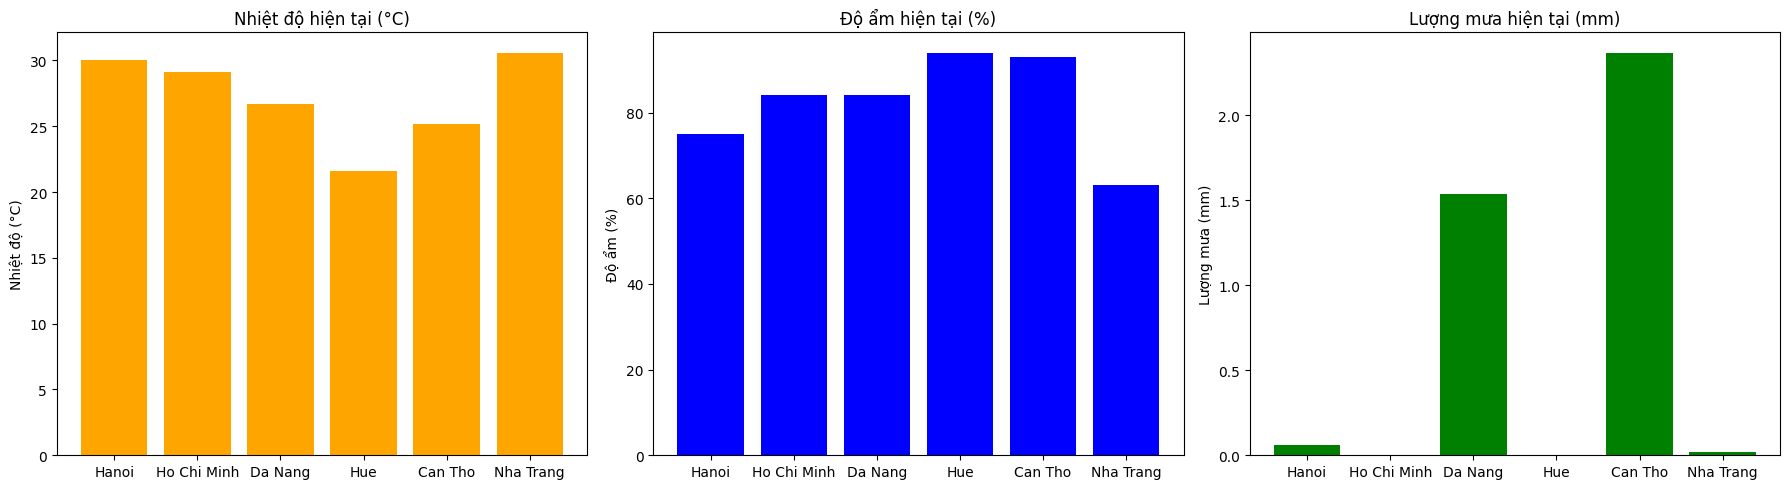

In [19]:
api_key = "c3c6aed84bbe41ac82951155251805"
# Danh sách các thành phố cần lấy dữ liệu
cities = ["Hanoi", "Ho Chi Minh", "Da Nang", "Hue", "Can Tho", "Nha Trang"]

# Các danh sách dùng để lưu trữ dữ liệu thu được
successful_cities = []
temperatures = []
humidities = []
precipitations = []
weather_data = []
print("Đang lấy dữ liệu thời tiết từ WeatherAPI...\n")

for city in cities:
    url = f"http://api.weatherapi.com/v1/current.json?key={api_key}&q={city}"
    response = requests.get(url)
    data = response.json()

    if response.status_code == 200 and "current" in data:
        temp = data["current"]["temp_c"]           # Nhiệt độ (°C)
        hum = data["current"]["humidity"]          # Độ ẩm (%)
        precip = data["current"]["precip_mm"]      # Lượng mưa (mm)

        successful_cities.append(city)
        temperatures.append(temp)
        humidities.append(hum)
        precipitations.append(precip)

        print(f"Thành công: {city} | Nhiệt độ: {temp}°C | Độ ẩm: {hum}% | Lượng mưa: {precip} mm")
    else:
        error_msg = data.get("error", {}).get("message", "Không xác định được lỗi")
        print(f"Thất bại: {city} - {error_msg}")

# Vẽ biểu đồ nếu có dữ liệu
if successful_cities:
    print("\nVẽ biểu đồ...\n")
    plt.figure(figsize=(18, 5))

    # Biểu đồ nhiệt độ
    plt.subplot(1, 3, 1)
    plt.bar(successful_cities, temperatures, color='orange')
    plt.title("Nhiệt độ hiện tại (°C)")
    plt.ylabel("Nhiệt độ (°C)")

    # Biểu đồ độ ẩm
    plt.subplot(1, 3, 2)
    plt.bar(successful_cities, humidities, color='blue')
    plt.title("Độ ẩm hiện tại (%)")
    plt.ylabel("Độ ẩm (%)")

    # Biểu đồ lượng mưa
    plt.subplot(1, 3, 3)
    plt.bar(successful_cities, precipitations, color='green')
    plt.title("Lượng mưa hiện tại (mm)")
    plt.ylabel("Lượng mưa (mm)")

    plt.tight_layout()
    plt.show()
else:
    print("Không có dữ liệu để hiển thị.")


In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType

spark = SparkSession.builder.appName("WeatherClustering").getOrCreate()

schema = StructType([
    StructField("city", StringType(), True),
    StructField("temp_c", DoubleType(), True),
    StructField("humidity", DoubleType(), True),
    StructField("precip_mm", DoubleType(), True),
    StructField("timestamp", LongType(), True),
])

if weather_data:
    df = spark.createDataFrame(weather_data, schema=schema)
else:
    print("⚠️ weather_data rỗng — tạo DataFrame rỗng với schema để tránh lỗi.")
    df = spark.createDataFrame([], schema)

df.show(truncate=False)
df.printSchema()


⚠️ weather_data rỗng — tạo DataFrame rỗng với schema để tránh lỗi.
+----+------+--------+---------+---------+
|city|temp_c|humidity|precip_mm|timestamp|
+----+------+--------+---------+---------+
+----+------+--------+---------+---------+

root
 |-- city: string (nullable = true)
 |-- temp_c: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precip_mm: double (nullable = true)
 |-- timestamp: long (nullable = true)



In [21]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import time as _time

numeric_cols = ["temp_c", "humidity", "precip_mm"]
df_clean = df
for c in numeric_cols:
    df_clean = df_clean.filter(col(c).isNotNull())

# Nếu không có bản ghi hợp lệ, tạo ít dữ liệu demo để pipeline chạy thử
if df_clean.count() == 0:
    print("⚠️ Không có bản ghi hợp lệ; tạo dữ liệu mẫu để demo.")
    sample = [
        ("Hanoi", 30.0, 70.0, 0.0,  int(_time.time())),
        ("Ho Chi Minh", 32.5, 65.0, 1.2, int(_time.time())),
        ("Da Nang", 29.0, 80.0, 3.5, int(_time.time())),
        ("Hue", 28.0, 85.0, 5.0,  int(_time.time())),
        ("Can Tho", 31.0, 72.0, 0.0,  int(_time.time())),
        ("Nha Trang", 30.5, 68.0, 0.5,  int(_time.time())),
    ]
    df_clean = spark.createDataFrame(sample, schema=schema)

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features_raw")
df_vec = assembler.transform(df_clean)

scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)
df_scaled = scaler.fit(df_vec).transform(df_vec)

evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", metricName="silhouette")
best_k, best_s, best_model = None, -1.0, None

for k in range(2, 7):
    km = KMeans(k=k, seed=42, featuresCol="features", predictionCol="prediction")
    m = km.fit(df_scaled)
    s = evaluator.evaluate(m.transform(df_scaled))
    print(f"k={k}: silhouette={s:.4f}")
    if s > best_s:
        best_k, best_s, best_model = k, s, m

print(f"→ Chọn k={best_k} (silhouette={best_s:.4f})")
best_model.transform(df_scaled).select("city", "temp_c", "humidity", "precip_mm", "prediction").show(truncate=False)


⚠️ Không có bản ghi hợp lệ; tạo dữ liệu mẫu để demo.
k=2: silhouette=0.8582
k=3: silhouette=0.5258
k=4: silhouette=0.4168
k=5: silhouette=0.1657
k=6: silhouette=0.0000
→ Chọn k=2 (silhouette=0.8582)
+-----------+------+--------+---------+----------+
|city       |temp_c|humidity|precip_mm|prediction|
+-----------+------+--------+---------+----------+
|Hanoi      |30.0  |70.0    |0.0      |0         |
|Ho Chi Minh|32.5  |65.0    |1.2      |0         |
|Da Nang    |29.0  |80.0    |3.5      |1         |
|Hue        |28.0  |85.0    |5.0      |1         |
|Can Tho    |31.0  |72.0    |0.0      |0         |
|Nha Trang  |30.5  |68.0    |0.5      |0         |
+-----------+------+--------+---------+----------+



In [22]:
import requests, time
from datetime import datetime
from typing import Optional, Dict
api_key = "c3c6aed84bbe41ac82951155251805"
# Danh sách các thành phố cần lấy dữ liệu
cities = ["Hanoi", "Ho Chi Minh", "Da Nang", "Hue", "Can Tho", "Nha Trang"]

ITERATIONS = 10         # số lần lặp (mỗi phút 1 lần)
SLEEP_SECONDS = 60      # nghỉ giữa 2 lần lặp để mô phỏng dữ liệu theo thời gian
REQUEST_GAP = 1.2       # nghỉ giữa 2 request liên tiếp để tránh rate-limit
TIMEOUT = 15            # timeout mỗi request (giây)


In [23]:
def fetch_weatherapi(city: str) -> Optional[Dict]:
    url = f"https://api.weatherapi.com/v1/current.json?key={WEATHERAPI_KEY}&q={city}&aqi=no"
    try:
        r = requests.get(url, timeout=TIMEOUT)
        j = r.json()
        if r.status_code != 200 or "current" not in j:
            err = (j.get("error") or {}).get("message", f"HTTP {r.status_code}")
            print(f"[WeatherAPI][{city}] Lỗi: {err}")
            return None

        cur = j["current"]
        ts = cur.get("last_updated_epoch") or j.get("location", {}).get("localtime_epoch")
        return {
            "timestamp": int(ts) if ts is not None else int(time.time()),
            "iso_time": datetime.now().isoformat(),
            "city": city,
            "temp_c": float(cur.get("temp_c")) if cur.get("temp_c") is not None else None,
            "humidity": float(cur.get("humidity")) if cur.get("humidity") is not None else None,
            "wind_kph": float(cur.get("wind_kph") or 0.0),
            "pressure_mb": float(cur.get("pressure_mb") or 0.0),
            "precip_mm": float(cur.get("precip_mm") or 0.0),
        }
    except Exception as e:
        print(f"[WeatherAPI][{city}] Exception: {e}")
        return None


In [24]:
# ==== Imports & cấu hình ====
import requests, time
from datetime import datetime
from typing import Optional, Dict
from urllib.parse import quote

# API key (WeatherAPI)
api_key = "c3c6aed84bbe41ac82951155251805"   # thay bằng key hợp lệ nếu cần
WEATHERAPI_KEY = api_key

# Tham số mô phỏng thu thập nhiều lần theo thời gian
ITERATIONS = 10          # số lần lặp
SLEEP_SECONDS = 60       # nghỉ giữa các lần lặp (giây)
REQUEST_GAP = 1.2        # nghỉ giữa 2 request liên tiếp để tránh rate-limit (giây)
TIMEOUT = 15             # timeout mỗi request (giây)

# Danh sách thành phố
CITIES = ["Hanoi", "Ho Chi Minh", "Da Nang", "Hue", "Can Tho", "Nha Trang"]


# ==== Hàm gọi WeatherAPI ====
def fetch_weatherapi(city: str) -> Optional[Dict]:
    """
    Lấy thời tiết hiện tại từ WeatherAPI cho 1 city.
    Trả về dict có các khóa: timestamp, iso_time, city, temp_c, humidity, wind_kph, pressure_mb, precip_mm.
    Trả về None nếu gặp lỗi.
    """
    url = f"https://api.weatherapi.com/v1/current.json?key={WEATHERAPI_KEY}&q={quote(city)}&aqi=no"
    try:
        r = requests.get(url, timeout=TIMEOUT)
        try:
            j = r.json()
        except Exception:
            j = {}

        if r.status_code != 200 or "current" not in j:
            err = (j.get("error") or {}).get("message", f"HTTP {r.status_code}")
            print(f"[WeatherAPI][{city}] Lỗi: {err}")
            return None

        cur = j["current"]
        loc = j.get("location", {})

        # Epoch cập nhật gần nhất
        ts = cur.get("last_updated_epoch") or loc.get("localtime_epoch") or int(time.time())

        # Ép kiểu an toàn
        def to_float(x, default=None):
            try:
                return float(x) if x is not None else default
            except Exception:
                return default

        return {
            "timestamp": int(ts),
            "iso_time": datetime.now().isoformat(),
            "city": city,
            "temp_c": to_float(cur.get("temp_c"), None),
            "humidity": to_float(cur.get("humidity"), None),
            "wind_kph": to_float(cur.get("wind_kph"), 0.0),
            "pressure_mb": to_float(cur.get("pressure_mb"), 0.0),
            "precip_mm": to_float(cur.get("precip_mm"), 0.0),
        }

    except requests.exceptions.Timeout:
        print(f"[WeatherAPI][{city}] Timeout sau {TIMEOUT}s.")
        return None
    except requests.exceptions.RequestException as e:
        print(f"[WeatherAPI][{city}] Lỗi mạng: {e}")
        return None
    except Exception as e:
        print(f"[WeatherAPI][{city}] Lỗi khác: {e}")
        return None


# ==== Thu thập theo thời gian ====
weather_data = []

for it in range(1, ITERATIONS + 1):
    print(f"\n=== Iteration {it}/{ITERATIONS} @ {datetime.now().isoformat()} ===")
    for city in CITIES:
        row = fetch_weatherapi(city)
        if row:
            weather_data.append(row)
            # dùng get để tránh KeyError nếu field None
            print(f"OK {city}: T={row.get('temp_c')}°C H={row.get('humidity')}% R={row.get('precip_mm')}mm")
        time.sleep(REQUEST_GAP)  # nghỉ giữa các request cho an toàn

    # nếu chưa phải lần cuối mới ngủ lâu
    if it < ITERATIONS:
        time.sleep(SLEEP_SECONDS)

print(f"\nTổng bản ghi thu được: {len(weather_data)}")
if weather_data:
    print("Mẫu 3 dòng:", weather_data[:3])
else:
    print("Chưa có bản ghi nào (kiểm tra API key/giới hạn gọi).")



=== Iteration 1/10 @ 2025-09-02T04:19:06.188931 ===
OK Hanoi: T=30.0°C H=75.0% R=0.06mm
OK Ho Chi Minh: T=29.1°C H=84.0% R=0.0mm
OK Da Nang: T=26.7°C H=84.0% R=1.54mm
OK Hue: T=21.6°C H=94.0% R=0.0mm
OK Can Tho: T=25.2°C H=93.0% R=2.37mm
OK Nha Trang: T=30.6°C H=63.0% R=0.02mm

=== Iteration 2/10 @ 2025-09-02T04:20:14.831849 ===
OK Hanoi: T=30.0°C H=75.0% R=0.06mm
OK Ho Chi Minh: T=29.1°C H=84.0% R=0.0mm
OK Da Nang: T=26.7°C H=84.0% R=1.54mm
OK Hue: T=21.6°C H=94.0% R=0.0mm
OK Can Tho: T=25.2°C H=93.0% R=2.37mm
OK Nha Trang: T=30.6°C H=63.0% R=0.02mm

=== Iteration 3/10 @ 2025-09-02T04:21:22.578811 ===
OK Hanoi: T=30.0°C H=75.0% R=0.06mm
OK Ho Chi Minh: T=29.1°C H=84.0% R=0.0mm
OK Da Nang: T=26.7°C H=84.0% R=1.54mm
OK Hue: T=21.6°C H=94.0% R=0.0mm
OK Can Tho: T=25.2°C H=93.0% R=2.37mm
OK Nha Trang: T=30.6°C H=63.0% R=0.02mm

=== Iteration 4/10 @ 2025-09-02T04:22:30.315288 ===
OK Hanoi: T=30.0°C H=75.0% R=0.06mm
OK Ho Chi Minh: T=29.4°C H=84.0% R=0.0mm
OK Da Nang: T=26.7°C H=84.0% R=1.

In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType

spark = SparkSession.builder.appName("WeatherClustering").getOrCreate()

schema = StructType([
    StructField("timestamp", LongType(), True),
    StructField("iso_time", StringType(), True),
    StructField("city", StringType(), True),
    StructField("temp_c", DoubleType(), True),
    StructField("humidity", DoubleType(), True),
    StructField("wind_kph", DoubleType(), True),
    StructField("pressure_mb", DoubleType(), True),
    StructField("precip_mm", DoubleType(), True),
])

# Luôn tạo DataFrame với schema cố định để tránh lỗi infer schema khi rỗng
data = spark.createDataFrame(weather_data if weather_data else [], schema)
data.cache()
data.printSchema()
data.show(10, truncate=False)
print("Số dòng:", data.count())


root
 |-- timestamp: long (nullable = true)
 |-- iso_time: string (nullable = true)
 |-- city: string (nullable = true)
 |-- temp_c: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- wind_kph: double (nullable = true)
 |-- pressure_mb: double (nullable = true)
 |-- precip_mm: double (nullable = true)

+----------+--------------------------+-----------+------+--------+--------+-----------+---------+
|timestamp |iso_time                  |city       |temp_c|humidity|wind_kph|pressure_mb|precip_mm|
+----------+--------------------------+-----------+------+--------+--------+-----------+---------+
|1756785600|2025-09-02T04:19:06.456308|Hanoi      |30.0  |75.0    |3.6     |1009.0     |0.06     |
|1756786500|2025-09-02T04:19:07.899716|Ho Chi Minh|29.1  |84.0    |14.8    |1009.0     |0.0      |
|1756786500|2025-09-02T04:19:09.337385|Da Nang    |26.7  |84.0    |4.7     |1009.0     |1.54     |
|1756786500|2025-09-02T04:19:10.766498|Hue        |21.6  |94.0    |14.0    |1012.0 

(A) Phân cụm theo từng quan sát

In [30]:
from pyspark.sql.functions import col

numeric_cols = ["temp_c", "humidity", "wind_kph", "pressure_mb", "precip_mm"]

# Lọc bỏ các bản ghi thiếu giá trị số bắt buộc
data_clean = data
for c in numeric_cols:
    data_clean = data_clean.filter(col(c).isNotNull())

print("Số dòng sau khi lọc thiếu:", data_clean.count())

# Nếu vẫn rỗng, tạo mẫu nhỏ để demo pipeline (bạn có thể bỏ khối này khi đã có dữ liệu thật)
if data_clean.count() == 0:
    import time as _time
    from datetime import datetime
    sample = [
        (int(_time.time()), datetime.now().isoformat(), "Hanoi",       30.0, 70.0,  8.0, 1006.0, 0.0),
        (int(_time.time()), datetime.now().isoformat(), "Ho Chi Minh", 32.5, 65.0, 10.0, 1004.0, 1.2),
        (int(_time.time()), datetime.now().isoformat(), "Da Nang",     29.0, 80.0, 12.0, 1008.0, 3.5),
        (int(_time.time()), datetime.now().isoformat(), "Hue",         28.0, 85.0,  7.0, 1009.0, 5.0),
        (int(_time.time()), datetime.now().isoformat(), "Can Tho",     31.0, 72.0,  9.0, 1005.0, 0.0),
        (int(_time.time()), datetime.now().isoformat(), "Nha Trang",   30.5, 68.0, 11.0, 1007.0, 0.5),
    ]
    data_clean = spark.createDataFrame(sample, schema=schema)


Số dòng sau khi lọc thiếu: 60


In [31]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Vector hoá + chuẩn hoá
assembler_obs = VectorAssembler(inputCols=numeric_cols, outputCol="features_raw_obs")
data_vec_obs = assembler_obs.transform(data_clean)

scaler_obs = StandardScaler(inputCol="features_raw_obs", outputCol="features_obs", withStd=True, withMean=True)
scaler_model_obs = scaler_obs.fit(data_vec_obs)
data_scaled_obs = scaler_model_obs.transform(data_vec_obs)

# Tìm k bằng silhouette
evaluator = ClusteringEvaluator(featuresCol="features_obs", predictionCol="cluster_obs", metricName="silhouette")
best_k_obs, best_s_obs, best_model_obs = None, -1.0, None

for k in range(2, 7):
    km = KMeans(k=k, seed=42, featuresCol="features_obs", predictionCol="cluster_obs")
    m = km.fit(data_scaled_obs)
    s = evaluator.evaluate(m.transform(data_scaled_obs))
    print(f"[OBS] k={k}: silhouette={s:.4f}")
    if s > best_s_obs:
        best_k_obs, best_s_obs, best_model_obs = k, s, m

print(f"→ [OBS] Chọn k={best_k_obs} (silhouette={best_s_obs:.4f})")

result_obs = best_model_obs.transform(data_scaled_obs)
result_obs.select("iso_time","city","temp_c","humidity","wind_kph","pressure_mb","precip_mm","cluster_obs") \
          .show(truncate=False)


[OBS] k=2: silhouette=0.5474
[OBS] k=3: silhouette=0.4858
[OBS] k=4: silhouette=0.7510
[OBS] k=5: silhouette=0.9274
[OBS] k=6: silhouette=0.9999
→ [OBS] Chọn k=6 (silhouette=0.9999)
+--------------------------+-----------+------+--------+--------+-----------+---------+-----------+
|iso_time                  |city       |temp_c|humidity|wind_kph|pressure_mb|precip_mm|cluster_obs|
+--------------------------+-----------+------+--------+--------+-----------+---------+-----------+
|2025-09-02T04:19:06.456308|Hanoi      |30.0  |75.0    |3.6     |1009.0     |0.06     |4          |
|2025-09-02T04:19:07.899716|Ho Chi Minh|29.1  |84.0    |14.8    |1009.0     |0.0      |3          |
|2025-09-02T04:19:09.337385|Da Nang    |26.7  |84.0    |4.7     |1009.0     |1.54     |5          |
|2025-09-02T04:19:10.766498|Hue        |21.6  |94.0    |14.0    |1012.0     |0.0      |2          |
|2025-09-02T04:19:12.197311|Can Tho    |25.2  |93.0    |8.6     |1009.0     |2.37     |1          |
|2025-09-02T04:19:

(B) Phân cụm theo thành phố (gộp trung bình theo thời gian)

In [32]:
from pyspark.sql.functions import avg

data_city = data_clean.groupBy("city").agg(
    avg("temp_c").alias("temp_c"),
    avg("humidity").alias("humidity"),
    avg("wind_kph").alias("wind_kph"),
    avg("pressure_mb").alias("pressure_mb"),
    avg("precip_mm").alias("precip_mm"),
)

data_city.show(truncate=False)

# Vector hoá + chuẩn hoá cho city
assembler_city = VectorAssembler(inputCols=numeric_cols, outputCol="features_raw_city")
data_vec_city = assembler_city.transform(data_city)

scaler_city = StandardScaler(inputCol="features_raw_city", outputCol="features_city", withStd=True, withMean=True)
scaler_model_city = scaler_city.fit(data_vec_city)
data_scaled_city = scaler_model_city.transform(data_vec_city)

# Chọn k theo silhouette
best_k_city, best_s_city, best_model_city = None, -1.0, None
evaluator_city = ClusteringEvaluator(featuresCol="features_city", predictionCol="cluster_city", metricName="silhouette")

for k in range(2, min(6, data_scaled_city.count()) + 1):  # k không vượt số city
    km = KMeans(k=k, seed=42, featuresCol="features_city", predictionCol="cluster_city")
    m = km.fit(data_scaled_city)
    s = evaluator_city.evaluate(m.transform(data_scaled_city))
    print(f"[CITY] k={k}: silhouette={s:.4f}")
    if s > best_s_city:
        best_k_city, best_s_city, best_model_city = k, s, m

print(f"→ [CITY] Chọn k={best_k_city} (silhouette={best_s_city:.4f})")

result_city = best_model_city.transform(data_scaled_city).select("city","temp_c","humidity","wind_kph","pressure_mb","precip_mm","cluster_city")
result_city.show(truncate=False)


+-----------+------------------+--------+--------+-----------+---------+
|city       |temp_c            |humidity|wind_kph|pressure_mb|precip_mm|
+-----------+------------------+--------+--------+-----------+---------+
|Da Nang    |26.7              |84.0    |4.7     |1009.0     |1.54     |
|Nha Trang  |30.6              |63.0    |8.3     |1006.0     |0.02     |
|Can Tho    |25.2              |93.0    |8.6     |1009.0     |2.37     |
|Hue        |21.6              |94.0    |14.0    |1012.0     |0.0      |
|Hanoi      |30.0              |75.0    |3.6     |1009.0     |0.06     |
|Ho Chi Minh|29.310000000000002|84.0    |14.8    |1009.0     |0.0      |
+-----------+------------------+--------+--------+-----------+---------+

[CITY] k=2: silhouette=0.1230
[CITY] k=3: silhouette=0.1778
[CITY] k=4: silhouette=0.0966
[CITY] k=5: silhouette=0.1955
[CITY] k=6: silhouette=0.0000
→ [CITY] Chọn k=5 (silhouette=0.1955)
+-----------+------------------+--------+--------+-----------+---------+---------

In [33]:
import numpy as np

centers_std = np.array(best_model_obs.clusterCenters())  # trong không gian chuẩn hoá
means = np.array(scaler_model_obs.mean.toArray())        # vector mean
stds  = np.array(scaler_model_obs.std.toArray())         # vector std

centers_orig = centers_std * stds + means
for i, center in enumerate(centers_orig):
    print(f"[OBS] Center {i} (gốc): temp={center[0]:.2f}°C, hum={center[1]:.2f}%, "
          f"wind={center[2]:.2f} kph, press={center[3]:.2f} mb, rain={center[4]:.2f} mm")


[OBS] Center 0 (gốc): temp=30.60°C, hum=63.00%, wind=8.30 kph, press=1006.00 mb, rain=0.02 mm
[OBS] Center 1 (gốc): temp=25.20°C, hum=93.00%, wind=8.60 kph, press=1009.00 mb, rain=2.37 mm
[OBS] Center 2 (gốc): temp=21.60°C, hum=94.00%, wind=14.00 kph, press=1012.00 mb, rain=-0.00 mm
[OBS] Center 3 (gốc): temp=29.31°C, hum=84.00%, wind=14.80 kph, press=1009.00 mb, rain=-0.00 mm
[OBS] Center 4 (gốc): temp=30.00°C, hum=75.00%, wind=3.60 kph, press=1009.00 mb, rain=0.06 mm
[OBS] Center 5 (gốc): temp=26.70°C, hum=84.00%, wind=4.70 kph, press=1009.00 mb, rain=1.54 mm


In [34]:
centers_std_c = np.array(best_model_city.clusterCenters())
means_c = np.array(scaler_model_city.mean.toArray())
stds_c  = np.array(scaler_model_city.std.toArray())

centers_orig_c = centers_std_c * stds_c + means_c
for i, center in enumerate(centers_orig_c):
    print(f"[CITY] Center {i} (gốc): temp={center[0]:.2f}°C, hum={center[1]:.2f}%, "
          f"wind={center[2]:.2f} kph, press={center[3]:.2f} mb, rain={center[4]:.2f} mm")


[CITY] Center 0 (gốc): temp=29.31°C, hum=84.00%, wind=14.80 kph, press=1009.00 mb, rain=0.00 mm
[CITY] Center 1 (gốc): temp=25.95°C, hum=88.50%, wind=6.65 kph, press=1009.00 mb, rain=1.96 mm
[CITY] Center 2 (gốc): temp=21.60°C, hum=94.00%, wind=14.00 kph, press=1012.00 mb, rain=0.00 mm
[CITY] Center 3 (gốc): temp=30.60°C, hum=63.00%, wind=8.30 kph, press=1006.00 mb, rain=0.02 mm
[CITY] Center 4 (gốc): temp=30.00°C, hum=75.00%, wind=3.60 kph, press=1009.00 mb, rain=0.06 mm


In [35]:
# Lưu bản theo quan sát
result_obs.write.mode("overwrite").parquet("weather_clusters_obs.parquet")
# Lưu bản theo city
result_city.write.mode("overwrite").parquet("weather_clusters_city.parquet")


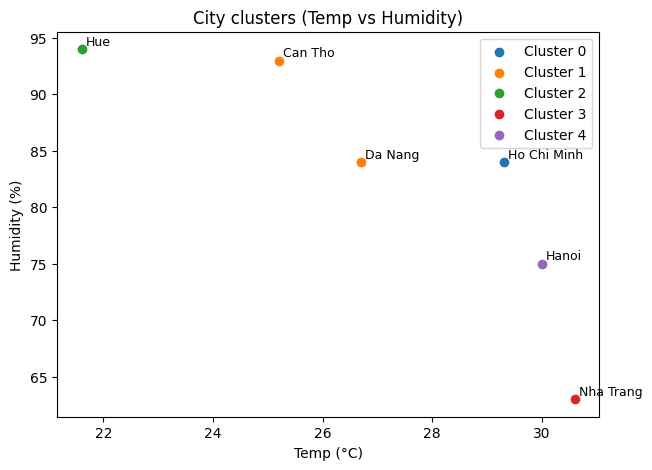

In [36]:
pdf_city = result_city.select("city","temp_c","humidity","cluster_city").toPandas()
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
for cl in sorted(pdf_city["cluster_city"].unique()):
    sub = pdf_city[pdf_city["cluster_city"] == cl]
    plt.scatter(sub["temp_c"], sub["humidity"], label=f"Cluster {cl}")
for _, row in pdf_city.iterrows():
    plt.annotate(row["city"], (row["temp_c"], row["humidity"]), fontsize=9, xytext=(3,3), textcoords="offset points")
plt.xlabel("Temp (°C)"); plt.ylabel("Humidity (%)"); plt.title("City clusters (Temp vs Humidity)")
plt.legend()
plt.show()


In [38]:
df = pd.DataFrame(weather_data )

In [39]:
print("Số bản ghi:", len(weather_data))
if weather_data[:3]:
    print("Mẫu 3 dòng đầu:", weather_data[:3])


Số bản ghi: 60
Mẫu 3 dòng đầu: [{'timestamp': 1756785600, 'iso_time': '2025-09-02T04:19:06.456308', 'city': 'Hanoi', 'temp_c': 30.0, 'humidity': 75.0, 'wind_kph': 3.6, 'pressure_mb': 1009.0, 'precip_mm': 0.06}, {'timestamp': 1756786500, 'iso_time': '2025-09-02T04:19:07.899716', 'city': 'Ho Chi Minh', 'temp_c': 29.1, 'humidity': 84.0, 'wind_kph': 14.8, 'pressure_mb': 1009.0, 'precip_mm': 0.0}, {'timestamp': 1756786500, 'iso_time': '2025-09-02T04:19:09.337385', 'city': 'Da Nang', 'temp_c': 26.7, 'humidity': 84.0, 'wind_kph': 4.7, 'pressure_mb': 1009.0, 'precip_mm': 1.54}]


In [40]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType

spark = SparkSession.builder.appName("WeatherClustering").getOrCreate()

schema = StructType([
    StructField("city", StringType(), True),
    StructField("temp_c", DoubleType(), True),
    StructField("humidity", DoubleType(), True),
    StructField("precip_mm", DoubleType(), True),
    StructField("timestamp", LongType(), True),  # hoặc StringType nếu bạn lưu ISO datetime
])


In [41]:
if weather_data and len(weather_data) > 0:
    # Nếu mỗi phần tử là dict với các key đúng như schema
    df = spark.createDataFrame(weather_data, schema=schema)
else:
    # Tạo DataFrame rỗng nhưng có schema để các bước sau vẫn chạy được
    df = spark.createDataFrame([], schema)
    print("⚠️ weather_data đang rỗng. Đã tạo DataFrame rỗng với schema để tránh lỗi.")


In [42]:
key_map = {"temperature": "temp_c", "humidity": "humidity", "precipitation": "precip_mm", "city": "city", "timestamp": "timestamp"}
normalized = []
for row in weather_data:
    normalized.append({
        "city": row.get("city"),
        "temp_c": float(row.get("temperature") if row.get("temperature") is not None else row.get("temp_c")),
        "humidity": float(row.get("humidity")) if row.get("humidity") is not None else None,
        "precip_mm": float(row.get("precipitation") if row.get("precipitation") is not None else row.get("precip_mm")),
        "timestamp": int(row.get("timestamp")) if row.get("timestamp") is not None else None,
    })
df = spark.createDataFrame(normalized, schema=schema) if normalized else spark.createDataFrame([], schema)


In [43]:
# Tạo SparkSession
spark = SparkSession.builder \
    .appName("WeatherClustering") \
    .getOrCreate()

# Chuyển data vào Spark DataFrame
df = spark.createDataFrame(weather_data)

In [44]:
import requests, time
from datetime import datetime, timedelta, timezone

# Danh sách TP Việt Nam và toạ độ gần đúng
cities = [
    {"city": "Hanoi", "lat": 21.0278, "lon": 105.8342},
    {"city": "Ho Chi Minh", "lat": 10.8231, "lon": 106.6297},
    {"city": "Da Nang", "lat": 16.0544, "lon": 108.2022},
    {"city": "Hue", "lat": 16.4637, "lon": 107.5909},
    {"city": "Can Tho", "lat": 10.0452, "lon": 105.7469},
    {"city": "Nha Trang", "lat": 12.2388, "lon": 109.1967},
]

# Lấy cửa sổ 24h để có lượng mưa giờ gần nhất
now_utc = datetime.now(timezone.utc)
start = (now_utc - timedelta(hours=24)).strftime("%Y-%m-%dT%H:00")
end   = now_utc.strftime("%Y-%m-%dT%H:00")

weather_data = []

for item in cities:
    lat, lon, city = item["lat"], item["lon"], item["city"]
    url = (
        "https://api.open-meteo.com/v1/forecast"
        f"?latitude={lat}&longitude={lon}"
        "&current=temperature_2m,relative_humidity_2m,precipitation"
        f"&hourly=precipitation&start_hour={start}&end_hour={end}"
        "&timezone=UTC"
    )
    try:
        r = requests.get(url, timeout=20)
        r.raise_for_status()
        j = r.json()

        cur = j.get("current", {})
        temp_c = cur.get("temperature_2m")
        humidity = cur.get("relative_humidity_2m")

        precip_mm = 0.0
        hourly = j.get("hourly", {})
        if hourly and "precipitation" in hourly and hourly["precipitation"]:
            precip_mm = float(hourly["precipitation"][-1] or 0.0)

        if temp_c is None and humidity is None:
            print(f"[{city}] Thiếu dữ liệu current, bỏ qua.")
            continue

        weather_data.append({
            "city": city,
            "temp_c": float(temp_c) if temp_c is not None else None,
            "humidity": float(humidity) if humidity is not None else None,
            "precip_mm": float(precip_mm),
            "timestamp": int(time.time()),
        })
    except Exception as e:
        print(f"[{city}] Lỗi: {e}")

print("Số bản ghi thu được:", len(weather_data))
weather_data[:3]


Số bản ghi thu được: 6


[{'city': 'Hanoi',
  'temp_c': 31.0,
  'humidity': 78.0,
  'precip_mm': 0.1,
  'timestamp': 1756791948},
 {'city': 'Ho Chi Minh',
  'temp_c': 30.3,
  'humidity': 74.0,
  'precip_mm': 0.6,
  'timestamp': 1756791949},
 {'city': 'Da Nang',
  'temp_c': 32.3,
  'humidity': 61.0,
  'precip_mm': 0.0,
  'timestamp': 1756791949}]

In [45]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType

schema = StructType([
    StructField("city", StringType(), True),
    StructField("temp_c", DoubleType(), True),
    StructField("humidity", DoubleType(), True),
    StructField("precip_mm", DoubleType(), True),
    StructField("timestamp", LongType(), True),
])

if weather_data:
    df = spark.createDataFrame(weather_data, schema=schema)
else:
    print("⚠️ weather_data rỗng — tạo DataFrame rỗng với schema để tránh lỗi.")
    df = spark.createDataFrame([], schema)

df.show(truncate=False)
df.printSchema()


+-----------+------+--------+---------+----------+
|city       |temp_c|humidity|precip_mm|timestamp |
+-----------+------+--------+---------+----------+
|Hanoi      |31.0  |78.0    |0.1      |1756791948|
|Ho Chi Minh|30.3  |74.0    |0.6      |1756791949|
|Da Nang    |32.3  |61.0    |0.0      |1756791949|
|Hue        |30.8  |75.0    |0.0      |1756791950|
|Can Tho    |29.8  |74.0    |0.8      |1756791950|
|Nha Trang  |27.1  |82.0    |4.8      |1756791951|
+-----------+------+--------+---------+----------+

root
 |-- city: string (nullable = true)
 |-- temp_c: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precip_mm: double (nullable = true)
 |-- timestamp: long (nullable = true)



In [46]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

numeric_cols = ["temp_c", "humidity", "precip_mm"]
df_clean = df
for c in numeric_cols:
    df_clean = df_clean.filter(col(c).isNotNull())

# Nếu vẫn rỗng (do API thiếu), tạo mẫu nhỏ để demo pipeline
if df_clean.count() == 0:
    print("⚠️ Không có bản ghi hợp lệ; tạo dữ liệu mẫu để demo.")
    sample = [
        ("Hanoi", 30.0, 70.0, 0.0,  int(time.time())),
        ("Ho Chi Minh", 32.5, 65.0, 1.2, int(time.time())),
        ("Da Nang", 29.0, 80.0, 3.5, int(time.time())),
        ("Hue", 28.0, 85.0, 5.0,  int(time.time())),
        ("Can Tho", 31.0, 72.0, 0.0,  int(time.time())),
        ("Nha Trang", 30.5, 68.0, 0.5,  int(time.time())),
    ]
    df_clean = spark.createDataFrame(sample, schema=schema)

# Vector hoá & chuẩn hoá
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features_raw")
df_vec = assembler.transform(df_clean)

scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)
df_scaled = scaler.fit(df_vec).transform(df_vec)

# Chọn k bằng Silhouette
evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", metricName="silhouette")
best_k, best_s, best_model = None, -1.0, None

for k in range(2, 7):
    km = KMeans(k=k, seed=42, featuresCol="features", predictionCol="prediction")
    m = km.fit(df_scaled)
    s = evaluator.evaluate(m.transform(df_scaled))
    print(f"k={k}: silhouette={s:.4f}")
    if s > best_s:
        best_k, best_s, best_model = k, s, m

print(f"→ Chọn k={best_k} (silhouette={best_s:.4f})")

result = best_model.transform(df_scaled)
result.select("city", "temp_c", "humidity", "precip_mm", "prediction").show(truncate=False)

# In tâm cụm trong không gian chuẩn hoá
for i, center in enumerate(best_model.clusterCenters()):
    print(f"Center {i}:", center)


k=2: silhouette=0.3931
k=3: silhouette=0.6155
k=4: silhouette=0.4717
k=5: silhouette=0.2280
k=6: silhouette=0.0000
→ Chọn k=3 (silhouette=0.6155)
+-----------+------+--------+---------+----------+
|city       |temp_c|humidity|precip_mm|prediction|
+-----------+------+--------+---------+----------+
|Hanoi      |31.0  |78.0    |0.1      |0         |
|Ho Chi Minh|30.3  |74.0    |0.6      |0         |
|Da Nang    |32.3  |61.0    |0.0      |1         |
|Hue        |30.8  |75.0    |0.0      |0         |
|Can Tho    |29.8  |74.0    |0.8      |0         |
|Nha Trang  |27.1  |82.0    |4.8      |2         |
+-----------+------+--------+---------+----------+

Center 0: [ 0.14822122  0.1767767  -0.36147461]
Center 1: [ 1.19533244 -1.83847763 -0.56229384]
Center 2: [-1.78821733  1.13137085  2.00819228]


In [47]:
import pandas as pd
pdf = pd.DataFrame(weather_data)  # nhìn cột nhanh
print(pdf.head())
df = spark.createDataFrame(pdf) if not pdf.empty else spark.createDataFrame([], schema)


          city  temp_c  humidity  precip_mm   timestamp
0        Hanoi    31.0      78.0        0.1  1756791948
1  Ho Chi Minh    30.3      74.0        0.6  1756791949
2      Da Nang    32.3      61.0        0.0  1756791949
3          Hue    30.8      75.0        0.0  1756791950
4      Can Tho    29.8      74.0        0.8  1756791950
